<a href="https://colab.research.google.com/github/YolandaMDavis/NSSADNN_IQA/blob/wildtrack-iqa/cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/WildTrack_Raw.zip', 'WildTrack_Raw.zip')

Mounted at /content/drive


'WildTrack_Raw.zip'

In [2]:
import math
import scipy.special
import numpy as np
import cv2
import scipy as sp

gamma_range = np.arange(0.2, 10, 0.001)
a = scipy.special.gamma(2.0/gamma_range)
a *= a
b = scipy.special.gamma(1.0/gamma_range)
c = scipy.special.gamma(3.0/gamma_range)
prec_gammas = a/(b*c)


def aggd_features(imdata):
    # flatten imdata
    imdata.shape = (len(imdata.flat),)
    imdata2 = imdata*imdata
    left_data = imdata2[imdata < 0]
    right_data = imdata2[imdata >= 0]
    left_mean_sqrt = 0
    right_mean_sqrt = 0
    if len(left_data) > 0:
        left_mean_sqrt = np.sqrt(np.average(left_data))
    if len(right_data) > 0:
        right_mean_sqrt = np.sqrt(np.average(right_data))

    if right_mean_sqrt != 0:
        gamma_hat = left_mean_sqrt/right_mean_sqrt
    else:
        gamma_hat = np.inf
    # solve r-hat norm

    imdata2_mean = np.mean(imdata2)
    if imdata2_mean != 0:
        r_hat = (np.average(np.abs(imdata))**2) / (np.average(imdata2))
    else:
        r_hat = np.inf
    rhat_norm = r_hat * (((math.pow(gamma_hat, 3) + 1) *
                          (gamma_hat + 1)) / math.pow(math.pow(gamma_hat, 2) + 1, 2))

    # solve alpha by guessing values that minimize ro
    pos = np.argmin((prec_gammas - rhat_norm)**2)
    alpha = gamma_range[pos]

    gam1 = scipy.special.gamma(1.0/alpha)
    gam2 = scipy.special.gamma(2.0/alpha)
    gam3 = scipy.special.gamma(3.0/alpha)

    aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
    bl = aggdratio * left_mean_sqrt
    br = aggdratio * right_mean_sqrt

    # mean parameter
    N = (br - bl)*(gam2 / gam1)  # *aggdratio
    return (alpha, N, bl, br, left_mean_sqrt, right_mean_sqrt)


def ggd_features(imdata):
    nr_gam = 1/prec_gammas
    sigma_sq = np.var(imdata)
    E = np.mean(np.abs(imdata))
    rho = sigma_sq/E**2
    pos = np.argmin(np.abs(nr_gam - rho))
    return gamma_range[pos], sigma_sq


def paired_product(new_im):
    shift1 = np.roll(new_im.copy(), 1, axis=1)
    shift2 = np.roll(new_im.copy(), 1, axis=0)
    shift3 = np.roll(np.roll(new_im.copy(), 1, axis=0), 1, axis=1)
    shift4 = np.roll(np.roll(new_im.copy(), 1, axis=0), -1, axis=1)

    H_img = shift1 * new_im
    V_img = shift2 * new_im
    D1_img = shift3 * new_im
    D2_img = shift4 * new_im

    return (H_img, V_img, D1_img, D2_img)


def calculate_mscn(dis_image):
    dis_image = dis_image.astype(np.float32) 
    ux = cv2.GaussianBlur(dis_image, (7, 7), 7/6)
    ux_sq = ux*ux
    sigma = np.sqrt(np.abs(cv2.GaussianBlur(dis_image**2, (7, 7), 7/6)-ux_sq))

    mscn = (dis_image-ux)/(1+sigma)

    return mscn


def ggd_features(imdata):
    nr_gam = 1/prec_gammas
    sigma_sq = np.var(imdata)
    E = np.mean(np.abs(imdata))
    rho = sigma_sq/E**2
    pos = np.argmin(np.abs(nr_gam - rho))
    return gamma_range[pos], sigma_sq


def extract_brisque_feats(mscncoefs):
    alpha_m, sigma_sq = ggd_features(mscncoefs.copy())
    pps1, pps2, pps3, pps4 = paired_product(mscncoefs)
    alpha1, N1, bl1, br1, lsq1, rsq1 = aggd_features(pps1)
    alpha2, N2, bl2, br2, lsq2, rsq2 = aggd_features(pps2)
    alpha3, N3, bl3, br3, lsq3, rsq3 = aggd_features(pps3)
    alpha4, N4, bl4, br4, lsq4, rsq4 = aggd_features(pps4)
    # print(alpha_m, alpha1)
    return [
        alpha_m, sigma_sq,
        alpha1, N1, lsq1**2, rsq1**2,  # (V)
        alpha2, N2, lsq2**2, rsq2**2,  # (H)
        alpha3, N3, lsq3**2, rsq3**2,  # (D1)
        alpha4, N4, lsq4**2, rsq4**2,  # (D2)
    ]


def brisque(im):
    mscncoefs = calculate_mscn(im)
    features1 = extract_brisque_feats(mscncoefs)
    lowResolution = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    features2 = extract_brisque_feats(lowResolution)
    print('features1', features1)
    print('features2', features2)
    return np.array(features1+features2)



In [3]:
import cv2
import numpy as np
from zipfile import ZipFile


def get_footprints(species):
  footprint = {}

  with ZipFile('WildTrack_Raw.zip', 'r') as zipObj:
    for filename in zipObj.namelist():
      if not filename.endswith(".jpg") or (len(species) > 0 and not any(x in filename for x in species)):
        continue # skip image
      with zipObj.open(filename) as image:
          # If we extracted files from zip, we can use cv2.imread(filename) instead
          print("Filename: {}".format(filename))
          img = cv2.imdecode(np.frombuffer(image.read(), np.uint8),cv2.COLOR_BGR2GRAY)
          footprint[filename] = cv2.resize(img, (1024, 1024))
  return footprint

species = ["Lion","Elephant"]
footprint = get_footprints(species)


Filename: RAW/Elephant_African_4/0a8a3624d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/18484ea4d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/151ee9d6d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/177cc752d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/0c36e300d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/11b3d6eed3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/12a18ecad3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/149edd36d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/0e42463ad3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/16f5f4a2d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/1232f690d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/159e4500d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/1670c9d0d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/de69acf0c0f911ea82a50242ac1c0002.jpg
Filename: RAW/Elepha

In [4]:
import re

footprint_matrix = []
footprint_label = []
footprint_brisque = []

regex = 'RAW\/\w+_(\d)\/.*'

for key, val in footprint.items():
    brisque_val = brisque(val)
    features = np.append(brisque_val, brisque_val)
    print(features)
    footprint_matrix.append(features)
    m = re.match(regex, key)
    score = int(m.group(1))
    if score >= 4:
      label = 1
    else:
      label = 0
    #label =  int(m.group(1))
    footprint_label.append(label)
 
# Create footprint matrix as (n_samples,n_pixels) matrix
footprint_matrix = np.array(footprint_matrix)
footprint_label = np.array(footprint_label)
footprint_brisque = np.array(footprint_brisque)


Streaming output truncated to the last 5000 lines.
features1 [2.299000000000002, 0.4024569, 0.7670000000000006, 0.12799716102555056, 0.10088186442278957, 0.26323102592256475, 0.7570000000000006, 0.05117350774221149, 0.14465557606279678, 0.21051315361218315, 0.8160000000000005, -0.04709782047941381, 0.18467084250190524, 0.12904934885756703, 0.8160000000000005, -0.0647213658776719, 0.19695050639136813, 0.12034789203195917]
features2 [9.999000000000008, 1170.443910429097, 9.999000000000008, 7.869574331705552, 0, 83.62923812866212, 9.999000000000008, 7.865741856444238, 0, 83.5478032430013, 9.999000000000008, 7.869703498537362, 0, 83.63198343912761, 9.999000000000008, 7.875345284600049, 0, 83.75193786621094]
[ 2.29900000e+00  4.02456909e-01  7.67000000e-01  1.27997161e-01
  1.00881864e-01  2.63231026e-01  7.57000000e-01  5.11735077e-02
  1.44655576e-01  2.10513154e-01  8.16000000e-01 -4.70978205e-02
  1.84670843e-01  1.29049349e-01  8.16000000e-01 -6.47213659e-02
  1.96950506e-01  1.2034789

In [5]:
import re

footprint_matrix = []
footprint_label = []
footprint_brisque = []

regex = 'RAW\/\w+_(\d)\/.*'

for key, val in footprint.items():

    mscncoefs = calculate_mscn(val)
    features = extract_brisque_feats(mscncoefs)
    footprint_matrix.append(np.array(features))
    m = re.match(regex, key)
    score = int(m.group(1))
    if score > 3:
      label = 1
    else:
      label = 0  
    footprint_label.append(label)



In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler

In [ ]:
# PCA
footprint_matrix_std = StandardScaler().fit_transform(footprint_matrix) 
footprint_pca = PCA().fit(footprint_matrix_std)



NameError: ignored

In [ ]:
# TSNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=5000)
tsne_results = tsne.fit_transform(footprint_matrix_std)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


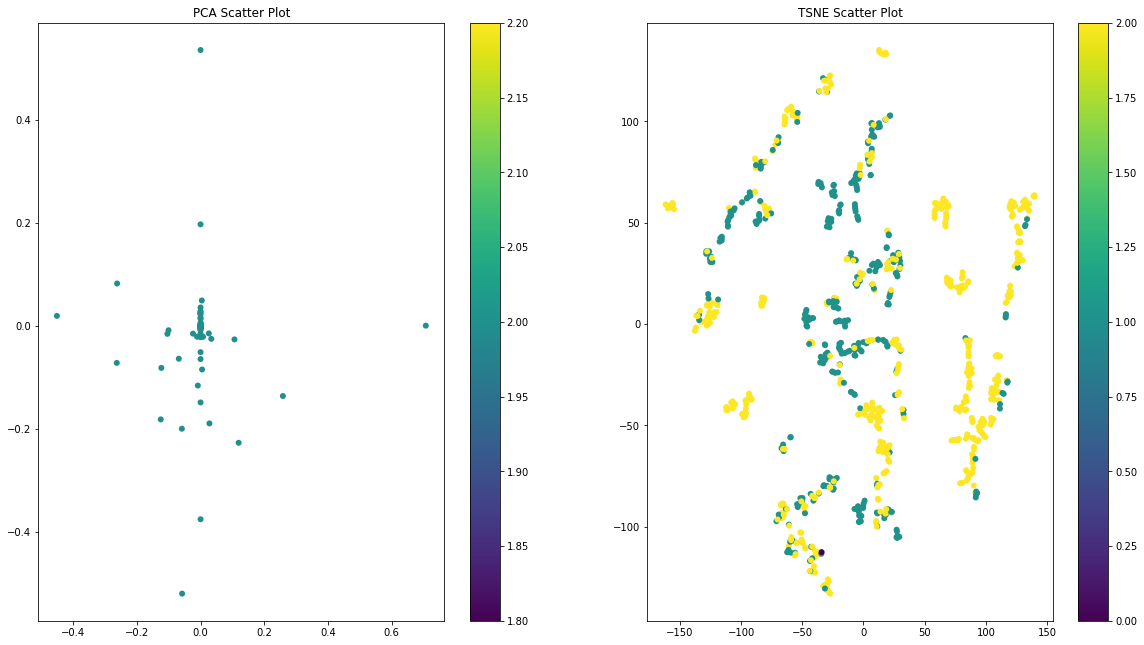

In [ ]:
from matplotlib import pyplot as plt

# eliminated last row due to outlier

plt.figure(figsize = (20,11))
plt.subplot(121)
plt.scatter(footprint_pca.components_[:,0], footprint_pca.components_[:,1], c = footprint_label[:72], edgecolor = "None")
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = footprint_label,  edgecolor = "None")
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

As seen above the data does not clearly separate amongst the different categories either in the case of PCA or TSNE clustering.  There is in TSNE some sort of order in the case of elephants,however this is not clearly seen when evaluating other species. 

This emphasizes that the features that we have may not be sufficient or that the scoring is inconsistent and doesn't follow a particular standard.



In [6]:
#Test historgram of first coefficient
import matplotlib.pyplot as plt

footprint_label = np.array(footprint_label)
lq_filter = footprint_label == 0
hq_filter = footprint_label == 1
columns = len(footprint_matrix[0])


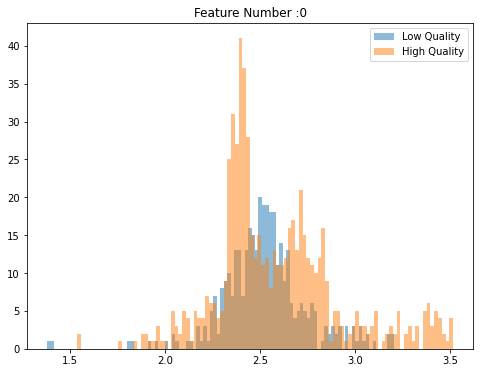

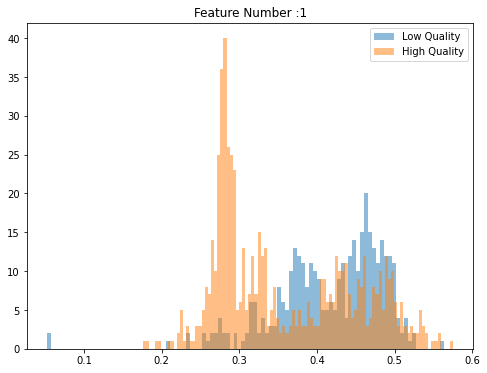

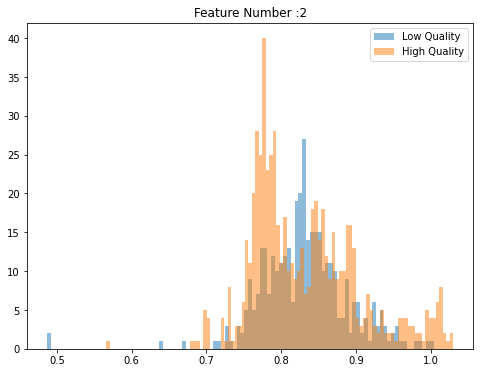

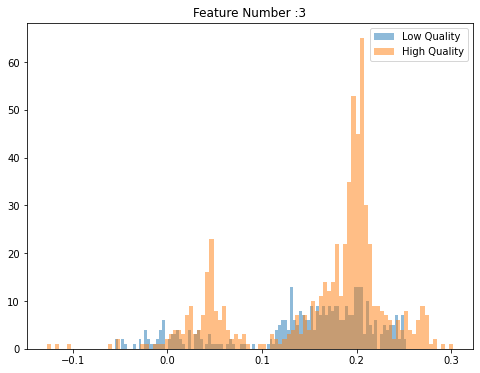

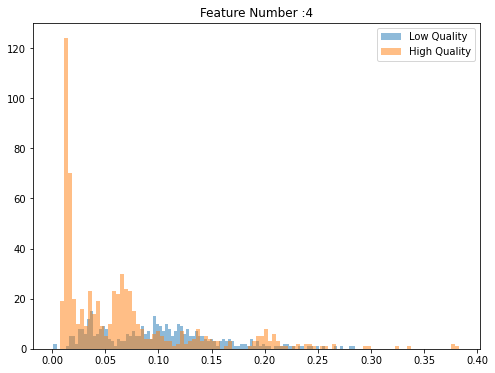

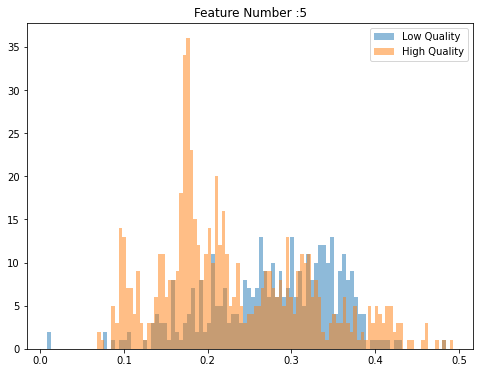

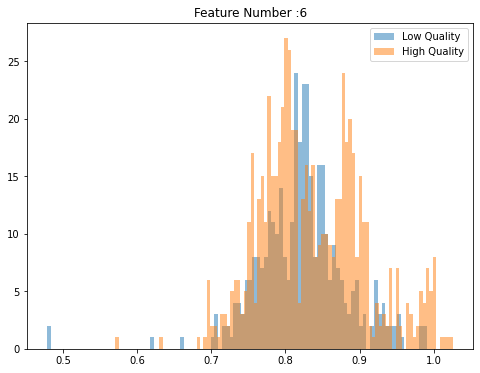

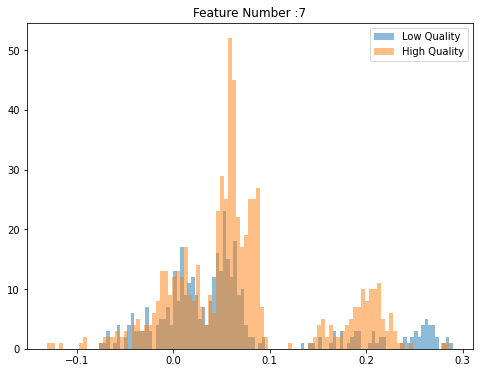

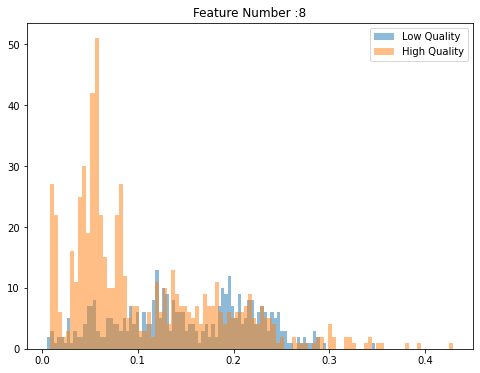

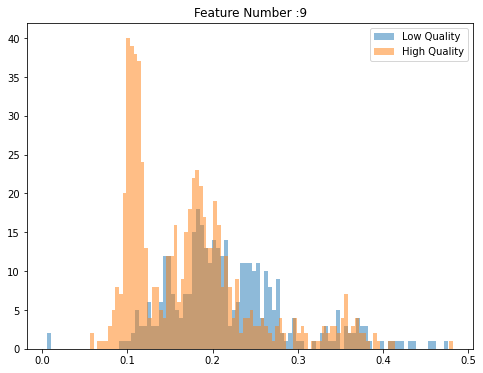

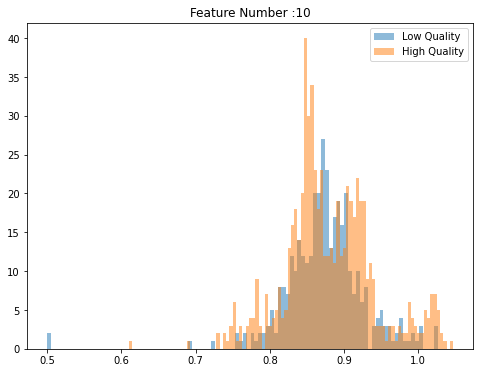

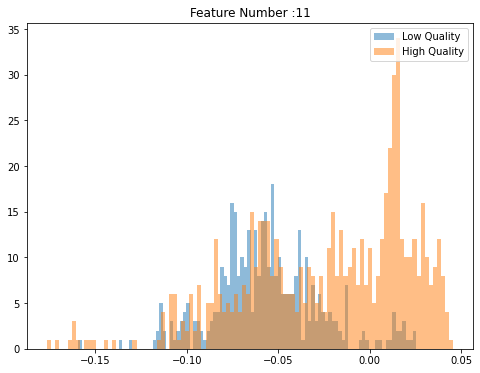

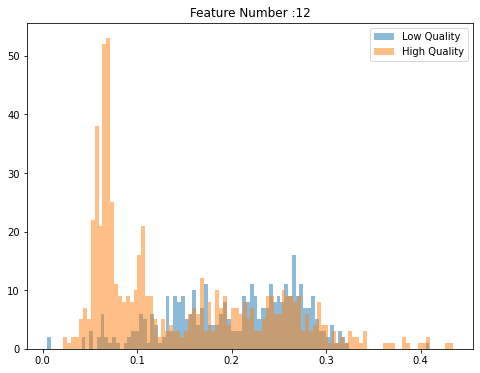

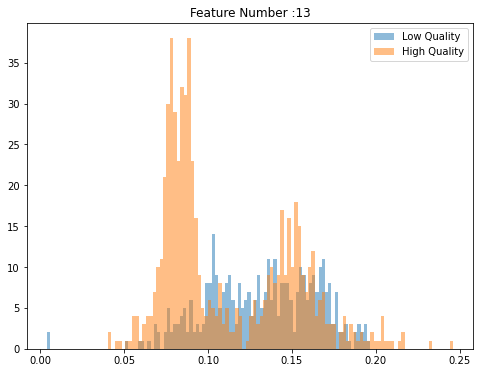

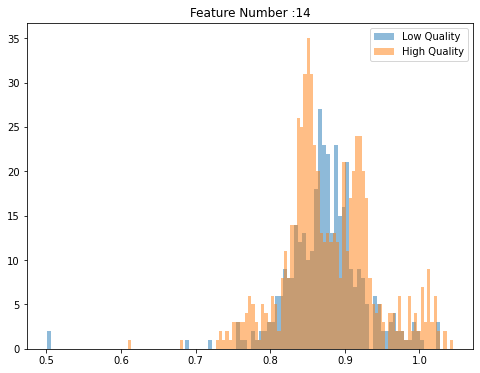

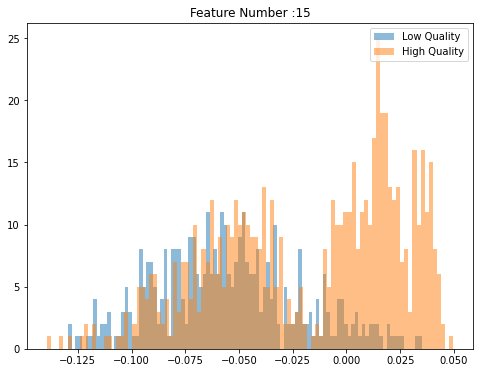

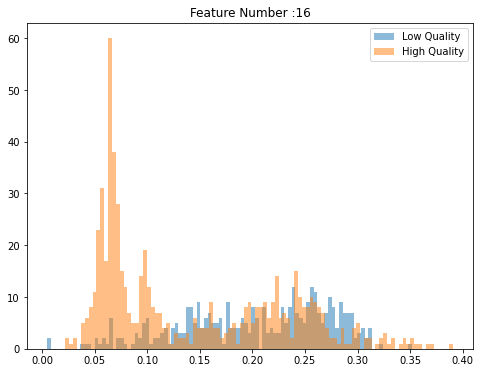

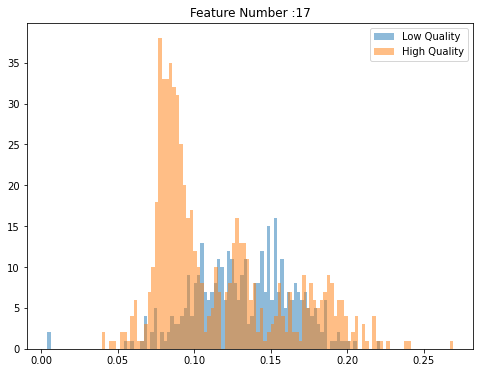

In [7]:

score_matrix = np.array(footprint_matrix)

for i in range(0,columns):
  lq_x = score_matrix[lq_filter, i]
  hq_x = score_matrix[hq_filter, i]

  plt.figure(figsize=(8,6))
  plt.title("Feature Number :" + str(i))
  plt.hist(lq_x, bins=100, alpha=0.5, label="Low Quality")
  plt.hist(hq_x, bins=100, alpha=0.5, label="High Quality")
  plt.legend(loc='upper right')
  plt.show() 

In [ ]:
score_matrix[:,0]

array([2.348, 2.254, 2.321, ..., 2.937, 2.401, 2.489])